In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import glob
import os
import seaborn as sns
import tensorflow as tf
import scipy
import glob
import sklearn 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import layers, models, optimizers
from tensorflow.keras.layers import Input, Activation, Dense, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.optimizers import Adam, SGD
from keras_tuner import BayesianOptimization, HyperParameters

2024-01-26 15:59:27.836971: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-26 15:59:27.837024: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-26 15:59:27.837060: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-26 15:59:27.845088: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-26 15:59:28.790753: W tensorflow/compiler/tf2t

***
### Clustering

In [2]:
folder_name_1 = 'AET_CF_Trial_12'
file_name_1 = '12_LSP_AET_CF_Predictions56'

folder_name_2 = 'AET_CF_All_Cluster_Trial_1'
if not os.path.exists(folder_name_2):
    os.makedirs(folder_name_2)
file_name_2 = '1_LSP_AET_CF_'

folder_name_3 = 'AET_CF_1_Cluster_Trial_1'

In [6]:
# read in and plot the original data set
latent = pd.read_pickle(f'{folder_name_1}/{file_name_1}')
latent = latent.replace({'trajectory-0.0': '0', 'trajectory-1.0': '1'}).infer_objects()

In [8]:
# Set the 'index' column as the new index
latent.set_index('index', inplace=True)

# Remove the name of the new index
latent.index.name = None

In [10]:
print(latent)

              x         y  z
28139  0.435840  0.182651  0
19395  0.488385  0.183984  1
21630  0.464089  0.128205  0
35529  0.500894  0.146142  1
35890  0.611763  0.427122  0
...         ...       ... ..
30911  0.506691  0.363621  0
17286  0.554290  0.159798  1
5926   0.565002  0.205167  1
36964  0.576408  0.253255  1
19674  0.158209  0.102874  0

[16000 rows x 3 columns]


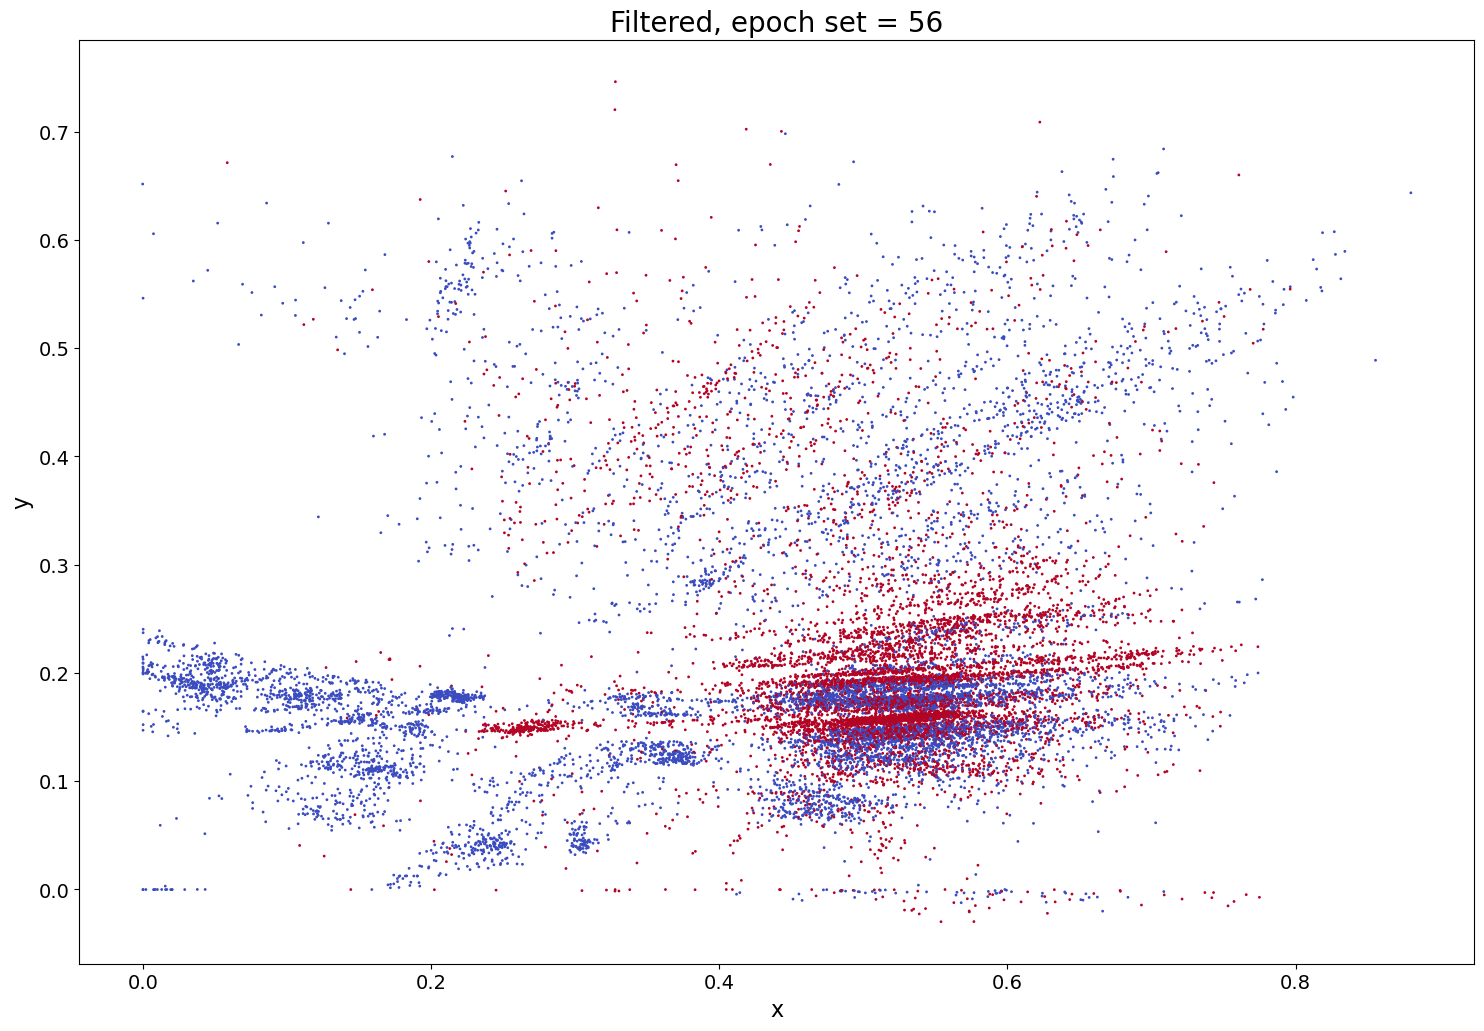

In [11]:
latent['z'] = pd.to_numeric(latent['z'], errors='coerce')

plt.figure(figsize=(18,12))
plt.scatter (latent.x,latent.y, c=latent.z, cmap="coolwarm", s = 1, alpha=1)
plt.title('Filtered, epoch set = 56', fontsize = 20)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize=16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize=14)
# plt.savefig("56_data.png", dpi = 300)

plt.show()

In [12]:
# remove the trajectory identity column for further processing
latent_n = latent.drop(['z'], axis = 1)

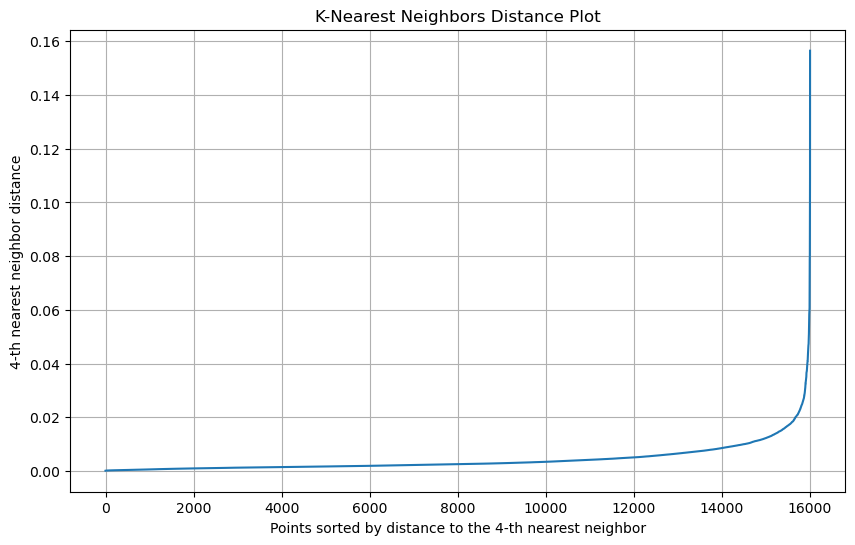

In [13]:
def plot_knn_distances(latent_n, k=4):
    """
    Plot the k-nearest neighbors distance for each point in the dataset to help
    determine a good 'eps' value for DBSCAN.

    Parameters:
    - data: The dataset (as a numpy array or similar).
    - k: The number of neighbors to consider (typically the same as 'min_samples' in DBSCAN).
    """
    # Compute the nearest neighbors
    nn = NearestNeighbors(n_neighbors=k).fit(latent_n)
    distances, _ = nn.kneighbors(latent_n)

    # Sort and plot the distances
    sorted_distances = np.sort(distances[:, k-1], axis=0)
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_distances)
    plt.xlabel('Points sorted by distance to the {}-th nearest neighbor'.format(k))
    plt.ylabel('{}-th nearest neighbor distance'.format(k))
    plt.title('K-Nearest Neighbors Distance Plot')
    plt.grid(True)
    plt.show()

# Then call the function with your data
# plot_knn_distances(df55.values, k=4) 


plot_knn_distances(latent.values, k=4)  # Adjust 'k' as needed

Number of clusters: 10


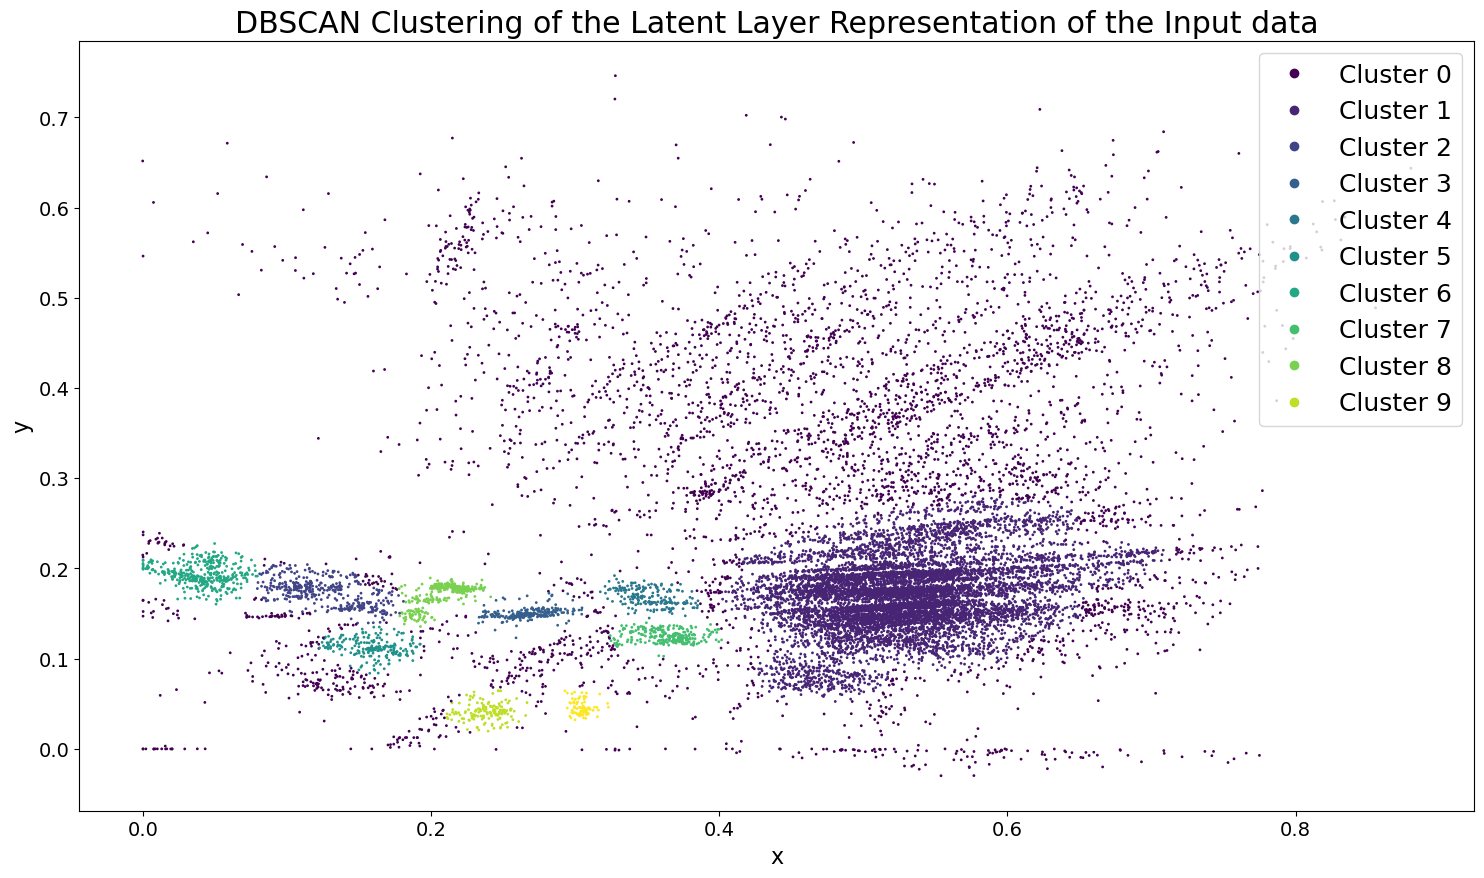

In [14]:
y_pred = DBSCAN(eps=0.015, min_samples=60).fit_predict(latent_n)

plt.rcParams['font.size'] = '18'
plt.figure(figsize=(18,10))

# Scatter plot assigning to a variable
scatter = plt.scatter(latent_n.iloc[:,0], latent_n.iloc[:,1], c=y_pred, s=1)

# Creating a legend
unique_labels = np.unique(y_pred)
# Filter out the noise label (-1) if present
unique_labels = unique_labels[unique_labels != -1]
legend_labels = ['Cluster {}'.format(lbl) for lbl in unique_labels]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, loc='upper right')

# Setting labels, titles, and ticks
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('DBSCAN Clustering of the Latent Layer Representation of the Input data')

# Print the number of clusters
print('Number of clusters: {}'.format(len(unique_labels)))

In [15]:
# latent_n is DataFrame after removing the 'z' column
# latent is the original DataFrame with the 'z' column

# Add the cluster labels to your DataFrame
latent_n['cluster'] = y_pred
latent['cluster'] = y_pred

# Reattach the 'z' column
latent_n['z'] = latent['z']

# Group by cluster and trajectory identity, then count the occurrences
cluster_trajectory_count = latent_n.groupby(['cluster', 'z']).size().reset_index(name='count')

print(cluster_trajectory_count)

    cluster  z  count
0        -1  0   2706
1        -1  1   1573
2         0  0   3367
3         0  1   6098
4         1  0    385
5         1  1      3
6         2  0     12
7         2  1    250
8         3  0    149
9         3  1     56
10        4  0    215
11        5  0    383
12        6  0    239
13        6  1     13
14        7  0    313
15        7  1      3
16        8  0    150
17        8  1      2
18        9  0     81
19        9  1      2


/home/chaseflynn/anaconda3/envs/2one/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/chaseflynn/anaconda3/envs/2one/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


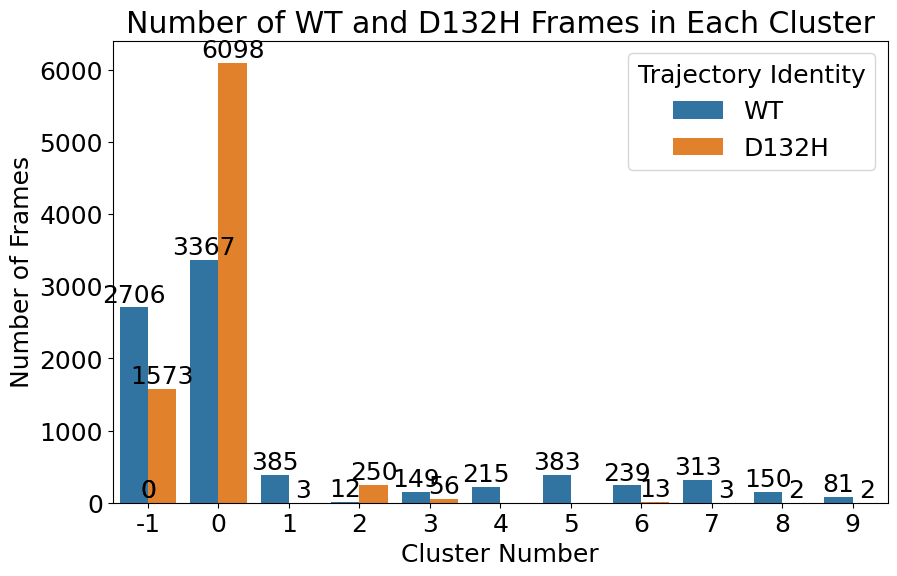

In [16]:
# 0 is WT and 1 is D132H
cluster_trajectory_count['z'] = cluster_trajectory_count['z'].replace({0: 'WT', 1: 'D132H'})

# Create the bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='cluster', y='count', hue='z', data=cluster_trajectory_count)

# Setting labels and title
plt.xlabel('Cluster Number')
plt.ylabel('Number of Frames')
plt.title('Number of WT and D132H Frames in Each Cluster')
plt.xticks(rotation=0)
plt.legend(title='Trajectory Identity')

# Annotate each bar with its count
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

# Show the plot
plt.show()

In [17]:
# Drop the first 2 columns
latent.drop(['x', 'y'], axis=1, inplace=True)

In [18]:
# Load recluster data
# recluster = pd.read_csv(f'{folder_name_2}/recluster.csv', index_col=0)
y_valid_f = pd.read_csv(f'{folder_name_1}/y_valid_f.csv', index_col=0)
X_valid_f = pd.read_csv(f'{folder_name_1}/X_valid_f.csv', index_col=0)
X_train_f = pd.read_csv(f'{folder_name_1}/X_train_f.csv', index_col=0)

In [19]:
# Read the original data
original_data = pd.read_csv(f'{folder_name_1}/X_valid_f.csv', index_col=0)

# Assuming 'latent_n' is a DataFrame with cluster information
unique_clusters = latent_n['cluster'].unique()

for cluster_number in unique_clusters:
    # Select indices of the current cluster
    selected_cluster_indices = latent_n[latent_n['cluster'] == cluster_number].index

    # Filter the data for the current cluster using loc for label-based indexing
    filtered_data = original_data.loc[selected_cluster_indices]

    # Save the filtered data for the current cluster
    filtered_data.to_csv(f'{folder_name_2}/Recluster_Latent_{cluster_number}.csv')

    # Save indices of the filtered data for the current cluster
    # Assuming 'latent' is defined and has the relevant indices
    latent[latent['cluster'] == cluster_number].to_csv(f'{folder_name_2}/Recluster_Index_{cluster_number}.csv')

# Latent Space of Clusters

In [20]:
# Loading autoencoder model from second round of training
model_path = f'{folder_name_3}/models/saved_model_1_LSP_AET_CF_56'
autoencoder = tf.keras.models.load_model(model_path)

dr_model = tf.keras.models.Model(inputs=autoencoder.get_layer('ae_input').input,
                                 outputs=autoencoder.get_layer('ae_latent').output)

2024-01-26 16:05:21.690868: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [21]:
clusters = [1, 2, 3]  # Replace with desired clusters

# Initialize an empty DataFrame for all clusters
select_clusters_df = pd.DataFrame()

print(select_clusters_df)

for cluster in clusters:
    # Load the data for the current cluster
    latent_file = f'{folder_name_2}/Recluster_Latent_{cluster}.csv'
    index_file = f'{folder_name_2}/Recluster_Index_{cluster}.csv'

    latent_data = pd.read_csv(latent_file, index_col=0)
    
    # Load the index_data with the first column as the index
    index_data = pd.read_csv(index_file, header=None, names=['z', 'cluster'], index_col=0)

    # Convert the data to numpy array if necessary
    X_batch = latent_data.values

    # Generate latent space representations
    latent_representations = dr_model.predict(X_batch)

    # Create DataFrame for current cluster and append to all_clusters_df
    df = pd.DataFrame(latent_representations, columns=['x', 'y'])
    df['z'] = index_data['z']
    df['cluster'] = index_data['cluster']
    select_clusters_df = select_clusters_df.append(df, ignore_index=True)

# Visualization and saving single .png file for all clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='x', y='y', hue='cluster', data=all_clusters_df, s=10, palette='viridis')
plt.title('Latent Space Representation - All Clusters')
plt.legend(title='Cluster')
png_path = os.path.join(folder_name_2, '1_LSP_AET_CF_All_Clusters.png')
plt.savefig(png_path, dpi=300)
plt.close()

# Saving the combined data in pickle format
pickle_path = os.path.join(folder_name_2, '1_LSP_AET_CF_All_Clusters.pkl')
all_clusters_df.to_pickle(pickle_path)

print("Combined processing and saving completed for all specified clusters.")

Empty DataFrame
Columns: []
Index: []
15/15 [==============================] - 0s 984us/step


AttributeError: 'DataFrame' object has no attribute 'append'

In [22]:
import pandas as pd

# Create two sample DataFrames
df1 = pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6]})
df2 = pd.DataFrame({'A': [7, 8, 9], 'B': [10, 11, 12]})

# Print the original DataFrames
print("Original DataFrame 1:")
print(df1)
print("\nOriginal DataFrame 2:")
print(df2)

# Append df2 to df1
appended_df = df1.append(df2, ignore_index=True)

# Print the appended DataFrame
print("\nAppended DataFrame:")
print(appended_df)


Original DataFrame 1:
   A  B
0  1  4
1  2  5
2  3  6

Original DataFrame 2:
   A   B
0  7  10
1  8  11
2  9  12


AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
# Print the shape of the input data
print(f"Input Data Shape: {X_batch.shape}")

# Print the summary of dr_model
dr_model.summary()


# Clustering round 2

In [ ]:
folder_name = 'AET_CF_All_Cluster_Trial_1'
file_name = '1_LSP_AET_CF_Predictions56'

In [ ]:
print(latent)

In [ ]:
# read in and plot the original data set
latent = pd.read_pickle(f'{folder_name}/{file_name}')
latent = latent.replace({'trajectory0': 0, 'trajectory1': 1})

In [ ]:
print(latent)

In [ ]:
plt.figure(figsize=(18,12))
plt.scatter (latent.x,latent.y, c=latent.z, cmap="coolwarm", s = 1, alpha=1)
plt.title('Filtered, epoch set = 56', fontsize = 20)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize=16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize=14)
# plt.savefig("56_data.png", dpi = 300)

plt.show()

In [ ]:
# remove the trajectory identity column for further processing
latent_n = latent.drop(['z', 'index'], axis = 1)
print(latent_n)

In [ ]:
y_pred = DBSCAN(eps=0.015, min_samples=60).fit_predict(latent_n)
plt.rcParams['font.size'] = '18'
plt.figure(figsize=(18,10))
plt.scatter(latent_n.iloc[:,0], latent_n.iloc[:,1], c=y_pred,s = 1)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize=16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize=14)
plt.title('DBSCAN Clustering of the Latent Layer Representation of the Input data')
print('Number of clusters: {}'.format(len(set(y_pred[np.where(y_pred != -1)]))))

In [ ]:
# Add the cluster labels to your DataFrame
latent_n['cluster'] = y_pred

# Reattach the 'z' column
latent_n['z'] = latent['z']

# Group by cluster and trajectory identity, then count the occurrences
cluster_trajectory_count = latent_n.groupby(['cluster', 'z']).size().reset_index(name='count')

print(cluster_trajectory_count)

In [ ]:
# 0 is WT and 1 is D132H
cluster_trajectory_count['z'] = cluster_trajectory_count['z'].replace({0: 'WT', 1: 'D132H'})

# Create the bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='cluster', y='count', hue='z', data=cluster_trajectory_count)

# Setting labels and title
plt.xlabel('Cluster Number')
plt.ylabel('Number of Frames')
plt.title('Number of WT and D132H Frames in Each Cluster')
plt.xticks(rotation=0)
plt.legend(title='Trajectory Identity')

# Annotate each bar with its count
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

# Show the plot
plt.show()